<div>
    <h3><center><a href="https://its-live.jpl.nasa.gov/"><img align="middle" src="https://its-live-data.s3.amazonaws.com/documentation/ITS_LIVE_logo.png" width="400px"/></a></center></h3>
    <h2><center>Global Glacier Velocity Point Data Access</center></h2>
</div>

# Setting up a local environment (Try running the notebook without these 3 steps, it might work)

at the terminal:
>conda create --name pg7 -c conda-forge h5netcdf fiona shapely jupyter netcdf4 psutil h5py zarr matplotlib gdal xarray  boto3 pyproj ipympl ipyleaflet s3fs

activate newly created environment:
> conda activate pg7

start jupyter in browser
> jupyter notebook



In [1]:
%%capture
%matplotlib widget

import matplotlib
import markdown 
from ipywidgets import widgets, HTML, Output
import numpy as np

from velocity_widget import ITSLIVE

matplotlib.rcParams['figure.figsize'] = [9, 5]
matplotlib.rcParams["figure.autolayout"] = True

velocity_widget = ITSLIVE()

**Instructions**: Click and drag on the map to pan the field of view. Select locations by double-clicking on the map then press Plot. Once plotted you can change the Variable that is being shown and how the markers are colored using Plot By. You can drag individual points after they are placed to relocate them, and then Plot again or Clear markers to start over.
You can also single-click on the map to populate the Lat and Lon boxes then add a point using the Add Point. Lat and Lon can also be edited manually.
Hovering your cursor over the plot reveals tools to zoom, pan, and save the figure.

Press Export Data to generate comma separated value (.csv) files of the data. Press Download Data to retrieve locally. Export Data must be pressed each time new data is requested.
Check out the video tutorial if you're a visual learner:

<center><a href="https://www.youtube.com/watch?v=VYKsVvpVbmU" target="_blank"><img width="35%" src="https://its-live-data.s3.amazonaws.com/documentation/ITS_LIVE_widget_youtube.jpg"></a></center>


Data are Version 2 of the ITS_LIVE global glacier velocity dataset that provides up-to-date velocities from Sentinel-1, Sentinel-2, Landsat-8 and Landsat-9 data. Version 2 annual mosaics are coming soon, and will be followed by Landsat 7 and improved Landsat 9 velocities.
Please refer to the <b>[project website](https://its-live.jpl.nasa.gov/)</b> for known issues, citation and other product information.


In [2]:
dates_range = widgets.SelectionRangeSlider(
    options=[i for i in range(546)],
    index=(1, 120),
    continuous_update=False,
    description='Interval (days): ',
    orientation='horizontal',
    layout={'width': '90%',
            'display': 'flex'},
    style={'description_width': 'initial'})

variables =  widgets.Dropdown(
    options=['v', 'v_error', 'vx', 'vy'],
    description='Variable: ',
    disabled=False,
    value='v',
    layout={'width': '20%',
            'display': 'flex'},
    style={'description_width': 'initial'})

plot_type =  widgets.Dropdown(
    options=['location', 'satellite'],
    description='Plot By: ',
    disabled=False,
    value='location',
    layout={'width': '20%',
            'display': 'flex'},
    style={'description_width': 'initial'})

plot_button =  widgets.Button(
    description='Plot',
    button_style='primary',
    icon='line-chart',
    style={'description_width': 'initial'})

clear_button =  widgets.Button(
    description='Clear Points',
    # button_style='warning',
    icon="trash",
    style={'description_width': 'initial'})

latitude = widgets.BoundedFloatText(
    value=0.0,
    min=-90.0,
    max=90.0,
    step=0.1,
    description='Lat: ',
    disabled=False,
    style={'description_width': 'initial'},
    layout={'width': '20%',
            'display': 'flex'},
)

longitude = widgets.BoundedFloatText(
    value=0.0,
    min=-180.0,
    max=180.0,
    step=0.1,
    description='Lon: ',
    disabled=False,
    style={'description_width': 'initial'},
    layout={'width': '20%',
            'display': 'flex'},
)

add_button =  widgets.Button(
    description='Add Point',
    # button_style='info',
    icon="map-marker",
    style={'description_width': 'initial'})

include_running_mean =  widgets.Checkbox(
            value=False,
            description="Include Running Mean",
            style={'description_width': 'initial'},
            disabled=False,
            indent=False,
            tooltip="Plot running mean through each time series",
            layout=widgets.Layout(width="25%"),
        )

export_button = widgets.Button(
    description='Export Data',
    # button_style='info',
    icon="file-export",
    style={'description_width': 'initial'})

data_link = widgets.HTML(
    value="<br>"
)

# If this congiguration changes we need to rerun the cell.
config = { 
    "plot": "v", # or other ITS_LIVE variables: vx, vy ...
    "min_separation_days": 1,
    "max_separation_days": 90,
    "color_by": "location", # valid values: satellite, points
    "verbose": True, # print operations
    "runnig_mean": True,
    "coords": {
        "latitude": latitude,
        "longitude": longitude
    },
    "data_link": data_link
}


plot_button.on_click(velocity_widget.plot_time_series)
clear_button.on_click(velocity_widget.clear_points)

def update_variable(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["plot"] = variables.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_range(change):
        if change['type'] == 'change' and change['name'] == 'value':
            start, end = change['new']
            config["min_separation_days"] = start
            config["max_separation_days"] = end
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_plottype(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["color_by"] = plot_type.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def update_mean(change):
        if change['type'] == 'change' and change['name'] == 'value':
            config["running_mean"] = include_running_mean.value
            velocity_widget.set_config(config)
            velocity_widget.plot_time_series()
            
def add_point(event):
    coords = (latitude.value, longitude.value)
    velocity_widget.add_point(coords)
    
def export_ts(event):
    velocity_widget.export_data()


export_button.on_click(export_ts)


add_button.on_click(add_point)
dates_range.observe(update_range, 'value')
plot_type.observe(update_plottype, 'value')
variables.observe(update_variable, 'value')
include_running_mean.observe(update_mean, 'value')

layout = widgets.Layout(align_items='stretch',
                        display='flex',
                        flex_flow='row wrap',
                        border='none',
                        grid_template_columns="repeat(auto-fit, minmax(720px, 1fr))",
                        # grid_template_columns='48% 48%',
                        width='99%',
                        height='100%')

velocity_widget.set_config(config)

velocity_widget.fig.canvas.capture_scroll = True

# We render the widget
widgets.GridBox([
                 widgets.VBox([velocity_widget.map,
                               widgets.HBox([latitude, longitude, add_button, clear_button], layout=widgets.Layout(align_items="flex-start",
                                                                                                                   flex_flow='row wrap')),
                               dates_range,
                               widgets.HBox([plot_button, variables, plot_type, include_running_mean], layout=widgets.Layout(justify_content="flex-start",
                                                                                                                             flex_flow='row wrap'))],
                              layout=widgets.Layout(min_width="100%",
                                                    display="flex",
                                                    # height="100%",
                                                    # max_height="100%",
                                                    max_width="100%")),
                  widgets.VBox([
                               velocity_widget.fig.canvas,
                               widgets.HBox([export_button, data_link])
                               ], layout=widgets.Layout(min_width="720px",
                                                        overflow='scroll',
                                                        max_width="100%",
                                                        display='flex'))],
                 layout=layout)

GridBox(children=(VBox(children=(Map(center=[57.2, -49.43], controls=(ZoomControl(options=['position', 'zoom_i…

## Make sure that you selected a point, clicked on "Plot", and have the plot before running the next cells.
You can download one or multiple datacubes automatically with the following cells.

In [2]:
import xarray as xr
import numpy as np
import time

# Get the cube address
cubes = velocity_widget.dct.addresses
cubes = [*set(cubes)]
print(cubes)

['http://its-live-data.s3.amazonaws.com/datacubes/v02/N60W140/ITS_LIVE_vel_EPSG3413_G0120_X-3250000_Y350000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N60W130/ITS_LIVE_vel_EPSG3413_G0120_X-3250000_Y250000.zarr']


In [3]:
# Select your date range (careful the datacubes get heavy quickly)
sdate = '2018-01-01'
edate = '2020-01-01'

# Set the boundaries for cube downloading (example: from Sit'Tlein bed's boundaries)
xmin = -3349648
xmax = -3240000
ymin = 271000
ymax = 366621

# Set the quality threshold for each velocity slice (0 is poorest quality, 100 is best)
# Mean for malaspina is 40
threshold = 40

# Set folder's path where you want to save the datacube(s)
# example: path = 'C:/Data/Folder/'
path = 'A:/PHD/Scripts/Strain_rates/D2/'

try:
    mkdir(path)
except:
    print('Folder already exists')


In [5]:
# List of variables to drop for the download (we drop everything but the variables written below)
variables_drop = [ele for ele in list(
        xr.open_dataset(cubes[0], engine='zarr').variables
        ) if ele not in ['mid_date','x','y','acquisition_date_img1', 'acquisition_date_img2', 'date_center', 'date_dt', 'satellite_img1','satellite_img2', 'vx','vy','roi_valid_percentage']
]


for n in range(len(cubes)):

        url = cubes[n]

        # Load the valid indices
        valid = xr.open_dataset(cubes[n], engine='zarr').roi_valid_percentage.values

        # Grab the time values
        t = xr.open_dataset(cubes[n], engine='zarr').mid_date.values

        # Create a time mask, based on the validity of layers and the custom date-range
        t_mask = np.logical_and(valid>threshold, np.logical_and(t>np.datetime64(sdate), t<np.datetime64(edate)))
        

        start = time.time()
        xrds = xr.open_dataset(url,
                                engine='zarr',
                                drop_variables=variables_drop
                                ).sel(mid_date=t_mask,
                                        x=slice(xmin, xmax),
                                        y=slice(ymax, ymin)).load()

        print(f'downloaded {n} spatial slice {time.time()-start:8.1f} seconds')
        xrds.to_netcdf(f'{path}datacube_{n}.nc')

downloaded 0 spatial slice    368.0 seconds
downloaded 1 spatial slice    169.4 seconds


##### If you want to test your cubes

Run the following cells, just make sure that you actually grab a datacube.
The plot should show an image without too many holes... until today-

C:\Users\whisk\AppData\Local\Temp\ipykernel_17432\3195687253.py:9: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(xr.open_dataset(f'{path}datacube_6.nc').vx.values, axis = 0))


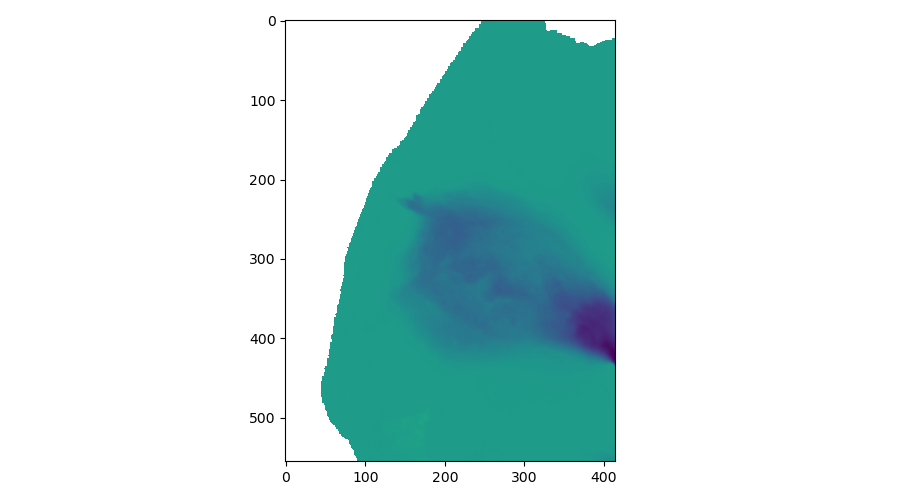

In [7]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import time

path = 'A:/PHD/Scripts/Strain_rates/Datacubes/'

plt.figure()
plt.imshow(np.nanmean(xr.open_dataset(f'{path}datacube_6.nc').vx.values, axis = 0))